**The objective of this task is to detect hate speech in tweets**. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets. Formally, given a training sample of tweets and labels, where **label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist**, the objective is to predict the labels on the test dataset.

Full tweet texts are provided with their labels for training data.
**Mentioned users' username is replaced with @user.**


## Importing Libraries

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1,h2 {
    text-align: center;
    background-color: blue;
    padding: 20px;
    margin: 0;
    color: white;
    font-family: ariel;
    border-radius: 80px
}

h3 {
    text-align: center;
    border-style: solid;
    border-width: 3px;
    padding: 12px;
    margin: 0;
    color: black;
    font-family: ariel;
    border-radius: 80px;
    border-color: gold;
}

body, p {
    font-family: ariel;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: ariel;
    color: purple;
}
</style>
""")

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re
import random
from collections import Counter
import warnings
warnings.filterwarnings("ignore")


import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
#from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve,auc
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve,auc,recall_score,precision_score
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PL

from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading in the Data and simple preprocessing

In [3]:
#in case of error Resource 'corpora/wordnet' not found. 
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [4]:
df = pd.read_csv('../input/twitter-sentiment-analysis-hatred-speech/train.csv')
df.head(10)

id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation
5   6      0  [2/2] huge fan fare and big talking before the...
6   7      0   @user camping tomorrow @user @user @user @use...
7   8      0  the next school year is the year for exams.ð...
8   9      0  we won!!! love the land!!! #allin #cavs #champ...
9  10      0   @user @user welcome here !  i'm   it's so #gr...

In [5]:
# Dropping the redundant column 'id'
df = df.drop('id',axis = 'columns')

In [6]:
print(f'The shape of the data is {df.shape}')

The shape of the data is (31962, 2)


# **Data Pre-Processing**

**Missing Values**

In [7]:
print(f'Checking for null values in data....... \n{df.isnull().any()}')

Checking for null values in data....... 
label    False
tweet    False
dtype: bool


In [8]:
#Dropping Duplicates
df = df.drop_duplicates(keep='first')

In [9]:
print(f'After checking for duplicates: The shape of the data is {df.shape}')

After checking for duplicates: The shape of the data is (29530, 2)


**Class Imbalance**

In [10]:
pos = 100*len(df.loc[df['label']==0,'label'])/len(df['label'])
neg = 100*len(df.loc[df['label']==1,'label'])/len(df['label'])
print(f'Percentage of Not Raciest/Sexiest (Postitive Sentiment) tweets is {pos}')
print(f'Percentage of Raciest/Sexiest (Negative Sentiment) tweets is {neg}')
print('\nClearly, The data is heavily Imbalanced')

Percentage of Not Raciest/Sexiest (Postitive Sentiment) tweets is 93.18320352184219
Percentage of Raciest/Sexiest (Negative Sentiment) tweets is 6.816796478157806

Clearly, The data is heavily Imbalanced


## Basic Feature Extraction Functions

In [11]:
stop_words = stopwords.words('english')

### Hashtags Count

#### **One interesting feature which we can extract from a tweet is to calculate the number of hashtags in it. It helps in extracting extra information from our text data.**

In [12]:
def num_of_hash_tags(df):
    df['hashtags_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

#### **Usually, negative sentiments contain a lesser amount of words than the positive ones. So, this is a feature worth trying out**

In [13]:
def num_of_words(df):
    df['word_count'] = df['tweet'].apply(lambda x : len(str(x).split(" ")))

### Character Count

In [14]:
def num_of_chars(df):
    df['char_count'] = df['tweet'].apply(lambda x: sum(list(map(len,x.split(' ')))))

### Number Count

#### **Just like we calculated the number ofa words and characters, we can also calculate the number of numerics which are present in the tweets. It might be a useful feature**

In [15]:
def num_of_num(df):
    df['num_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

### Stopwords Count

#### **Generally, while solving any NLP problem, the first thing we do is to remove the stopwords. A stop word is a commonly used word such as the, a, an, in which are filtered out before or after processing of natural language data (text).** 

In [16]:
def num_of_stop_words(df):
    df['stopwords_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x in stop_words]))

### Uppercase words

#### **Anger or rage is quite often expressed by writing in UPPERCASE words which makes this a necessary operation to identify those words.**

In [17]:
def num_of_upper(df):
    df['upper_case'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

### Feature Extraction Function

In [18]:
# def feature_extract(df):
#     num_of_hash_tags(df)
#     num_of_num(df)
#     num_of_chars(df)
#     num_of_stop_words(df)
#     num_of_upper(df)

## Text Preprocessing

In [19]:
# Lemmatization
Word = WordNetLemmatizer()

###  Removing hyperlinks and markup

In [20]:
def clean(raw):
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result) # greater than sign
    result = re.sub('&#x27;', "'", result) # apostrophe
#     result = re.sub('&quot;', '"', result) 
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result) # paragraph tag
    result = re.sub('<i>', ' ', result) #italics tag
    result = re.sub('</i>', '', result) 
    result = re.sub('&#62;', '', result)
    result = re.sub("\n", '', result) # newline 
    return result

### Removing Emojis

In [21]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

### Removing Punctuation and some symbols

####  **Removing punctuation as it doesn’t add any extra information while treating text data. Removing these symbols also helps reduce data size**

In [22]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)
    return text

### Converting text to lower case

In [23]:
def lower_case(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

### Removing Stopwords

#### **Generally, while solving any NLP problem, the first thing we do is to remove the stopwords. A stop word is a commonly used word such as the, a, an, in which are filtered out before or after processing of natural language data (text).** 

In [24]:
def stop_words_remove(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

### Removing the word user

#### **This has been done as the word user is just a placeholder for the actual user names and so, occurs many times without providing any useful information**

In [25]:
def remove_word_user(df):    
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x != 'user'))

### Spell Correction

In [26]:
def spell_correction(df):
    df['tweet'].apply(lambda x: str(TextBlob(x).correct()))

### Lemmatization

#### **Lemmatization is the process of converting a word to its base form. The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors. Lemmatization is a more effective option than stemming because it converts the word into its root word, rather than just stripping the suffices.**

In [27]:
def lemmatize(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join([Word.lemmatize(word) for word in x.split()]))

### Rare Words Removal

In [28]:
lst = pd.Series(' '.join(df['tweet']).split()).value_counts()[-5:]
lst = list(lst.index)
def rare_words_removal(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in lst))

### Cleaning Function

In [29]:
def cleaning(df):
    df['tweet'] = df['tweet'].apply(clean)
    df['tweet'] = df['tweet'].apply(deEmojify)
    df['tweet'] = df['tweet'].apply(lambda x: remove_punct(x))
    lower_case(df)
    stop_words_remove(df)
    remove_word_user(df)
#     rare_words_removal(df)
#     spell_correction(df)
    lemmatize(df)

In [30]:
# Calling the functions to extract features from my data and clean/preprocess it.
# feature_extract(df)
cleaning(df)

# tweets after cleaning 

In [31]:
df.head()

label                                              tweet
0      0  father dysfunctional selfish drag kid dysfunct...
1      0  thanks lyft credit cant use cause dont offer w...
2      0                                     bihday majesty
3      0                        model love u take u time ur
4      0                      factsguide society motivation

## Visualization through WordClouds

(-0.5, 399.5, 199.5, -0.5)

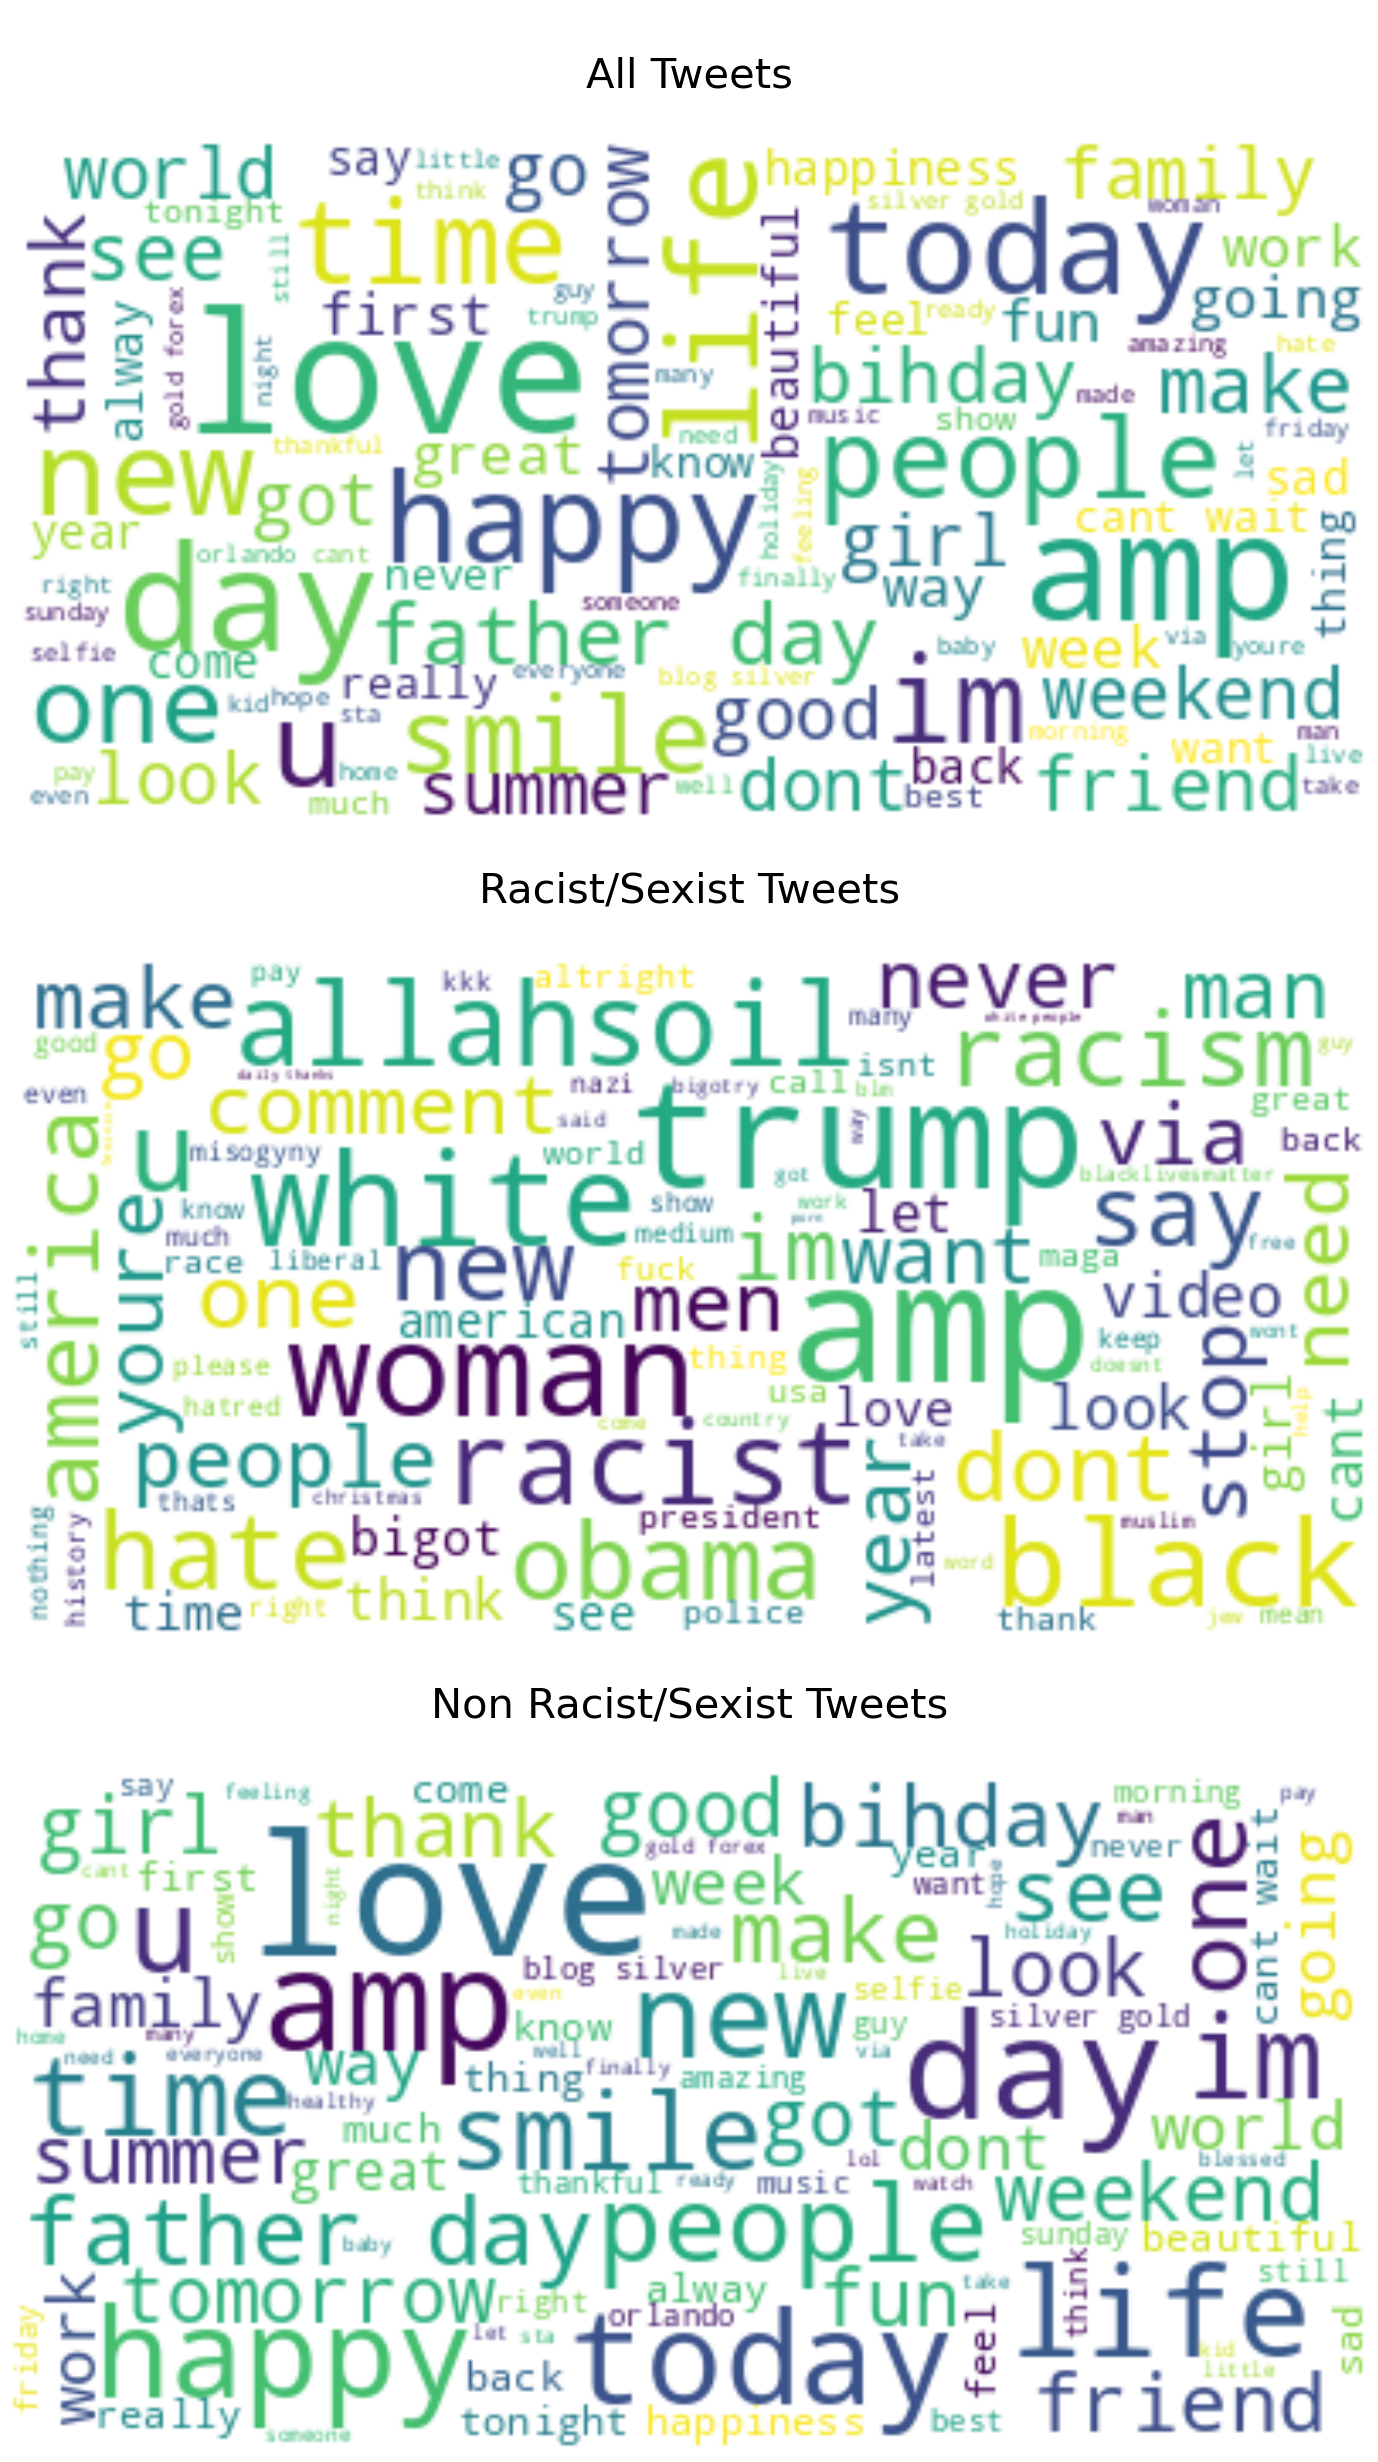

In [32]:
df_RS = df[df['label']==1]
df_NRS = df[df['label']==0]
tweet_All = " ".join(review for review in df.tweet)
tweet_RS = " ".join(review for review in df_RS.tweet)
tweet_NRS = " ".join(review for review in df_NRS.tweet)

fig, ax = plt.subplots(3, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)
wordcloud_RS = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_RS)
wordcloud_NRS = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_NRS)

# Display the generated image:
ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('\nAll Tweets\n', fontsize=30)
ax[0].axis('off')
print('\n')
ax[1].imshow(wordcloud_RS, interpolation='bilinear')
ax[1].set_title('\nRacist/Sexist Tweets\n',fontsize=30)
ax[1].axis('off')
print('\n')
ax[2].imshow(wordcloud_NRS, interpolation='bilinear')
ax[2].set_title('\nNon Racist/Sexist Tweets\n',fontsize=30)
ax[2].axis('off')


In [33]:
# Looking at the dataset after various transformations
df.head(20)

label                                              tweet
0       0  father dysfunctional selfish drag kid dysfunct...
1       0  thanks lyft credit cant use cause dont offer w...
2       0                                     bihday majesty
3       0                        model love u take u time ur
4       0                      factsguide society motivation
5       0  huge fan fare big talking leave chaos pay disp...
6       0                             camping tomorrow danny
7       0  next school year year exam cant think school e...
8       0  love land allin cavs champion cleveland clevel...
9       0                                      welcome im gr
10      0  ireland consumer price index mom climbed previ...
11      0  selfish orlando standwithorlando pulseshooting...
12      0                 get see daddy today day gettingfed
13      1  cnn call michigan middle school build wall cha...
14      1  comment australia opkillingbay seashepherd hel...
15      0            ouchjunior angry got junior yugyoem omg
16      0                   thankful paner thankful positive
17      1                                      retweet agree
18      0       friday smile around via ig cooky make people
19      0                   know essential oil made chemical

In [34]:
# Separating data and labels

X = df.drop('label', axis = 'columns')
y = df['label']

In [35]:
X

tweet
0      father dysfunctional selfish drag kid dysfunct...
1      thanks lyft credit cant use cause dont offer w...
2                                         bihday majesty
3                            model love u take u time ur
4                          factsguide society motivation
...                                                  ...
31956        fishing tomorrow carnt wait first time year
31957                                      ate isz youuu
31958  see nina turner airwave trying wrap mantle gen...
31959     listening sad song monday morning otw work sad
31961                                       thank follow

[29530 rows x 1 columns]

## Model Evaluation

In [36]:
# defining a function to evaluate my models based on certain metrics 
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"ROC-AUC score: \n {roc_auc_score(y_train,pred)}\n")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"ROC-AUC score: \n {roc_auc_score(y_test,pred)}\n")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

## Creating pipeline for tokenizing and modelling

In [37]:
# CounterVectorization takes any text document and returns each unique word as a feature with the count of number of times that word occurs.
# 


vector = CountVectorizer(stop_words= "english",max_features=10000, ngram_range = (1,2))

trans = vector.fit(X['tweet'])
x = trans.transform(X['tweet'])
X = X.drop('tweet',axis = 'columns')
X = pd.concat([X.reset_index(drop = True),pd.DataFrame(x.todense()).reset_index(drop = True)],axis = 'columns')
X = X.fillna(0)

In [38]:
print(x.shape, X.shape)

(29530, 10000) (29530, 10000)


In [39]:
# Dealing with imbalanced data

over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('over',over),('under', under)]
pipeline = PL(steps=steps)

X, y = pipeline.fit_resample(X, y)

In [40]:
# Standard stratified train test split being done here but other validation strategies can be explored

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 42,
                                                   test_size = 0.25,stratify=y)

# Vectorizarion

**Naive Bayes Classifier**

In [41]:
z=MultinomialNB()
z.fit(X_train,y_train)

pred=z.predict(X_test)

In [42]:
cm=confusion_matrix(y_test,pred)
print(cm)
score = accuracy_score( y_test, pred)
print(score)

[[5166  337]
 [1632 1120]]
0.7614778921865536


In [43]:
print("Classification Report")
print(classification_report(y_test, pred))

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      5503
           1       0.77      0.41      0.53      2752

    accuracy                           0.76      8255
   macro avg       0.76      0.67      0.69      8255
weighted avg       0.76      0.76      0.74      8255



**K-neighbor Classifier**

In [44]:
classifier = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
classifier.fit(X_train, y_train)

#predicting test results
kNpred = classifier.predict(X_test)

In [45]:
cm=confusion_matrix(y_test,kNpred)
print(cm)
score = accuracy_score( y_test, kNpred)
print(score)

[[2837 2666]
 [  39 2713]]
0.6723198061780739


In [46]:
print("Classification Report")
print(classification_report(y_test, kNpred))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.52      0.68      5503
           1       0.50      0.99      0.67      2752

    accuracy                           0.67      8255
   macro avg       0.75      0.75      0.67      8255
weighted avg       0.83      0.67      0.67      8255



<!-- **Logistic Regression Classifier** -->

LRC

In [47]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

print("Test  Accuracy : %.2f"%classifier.score(X_test, y_test))
print("Train Accuracy : %.2f"%classifier.score(X_train, y_train))
print()

#predicting test results
y_pred = classifier.predict(X_test)

Test  Accuracy : 0.92
Train Accuracy : 0.95



In [48]:
cm=confusion_matrix(y_test,y_pred)
print(cm)
score = accuracy_score( y_test, y_pred)
print(score)

[[5023  480]
 [ 180 2572]]
0.9200484554815264


In [49]:
print("Classification Report")
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      5503
           1       0.84      0.93      0.89      2752

    accuracy                           0.92      8255
   macro avg       0.90      0.92      0.91      8255
weighted avg       0.92      0.92      0.92      8255



SVM 

In [50]:
from sklearn import svm
classifier = svm.SVC(kernel='linear',random_state = 0)
classifier.fit(X_train, y_train)

print("Test  Accuracy : %.2f"%classifier.score(X_test, y_test))
print("Train Accuracy : %.2f"%classifier.score(X_train, y_train))
print()

#predicting test results
svm_pred = classifier.predict(X_test)

Test  Accuracy : 0.92
Train Accuracy : 0.97



In [51]:
cm=confusion_matrix(y_test,svm_pred)
print(cm)
score = accuracy_score( y_test, svm_pred)
print(score)

[[4993  510]
 [ 152 2600]]
0.9198061780738946


In [52]:
print("Classification Report")
print(classification_report(y_test, svm_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      5503
           1       0.84      0.94      0.89      2752

    accuracy                           0.92      8255
   macro avg       0.90      0.93      0.91      8255
weighted avg       0.93      0.92      0.92      8255



**XG Boost Classifier**

In [53]:
model = XGBClassifier()
model.fit(X_train, y_train)
XGB_pred = model.predict(X_test)

In [54]:
cm=confusion_matrix(y_test,XGB_pred)
print(cm)
score = accuracy_score( y_test, XGB_pred)
print(score)


[[4692  811]
 [ 275 2477]]
0.8684433676559661


In [55]:
print("Classification Report")
print(classification_report(y_test, XGB_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.85      0.90      5503
           1       0.75      0.90      0.82      2752

    accuracy                           0.87      8255
   macro avg       0.85      0.88      0.86      8255
weighted avg       0.88      0.87      0.87      8255



**Deep Learning Classification**

In [56]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, SpatialDropout1D
from keras.layers import Bidirectional

In [57]:
max_features = 220
tokenizer = Tokenizer(num_words = max_features, split = (' '))
tokenizer.fit_on_texts(df['tweet'].values)
X = tokenizer.texts_to_sequences(df['tweet'].values)
# making all the tokens into same sizes using padding.
X = pad_sequences(X, maxlen = max_features)
X.shape

(29530, 220)

In [58]:

Y = df['label'].values

# Optimization Algorithm: adam, Loss Function : Cross-Entropy

Cross-entropy loss decreases as the predicted probability converges to the actual label. It measures the performance of a classification model whose predicted output is a probability value between 0 and 1 .

The model also uses the efficient Adam optimization algorithm for gradient descent, and accuracy metrics will be collected when the model is trained.

In [59]:
model = Sequential()
model.add(Embedding(max_features, 64, input_length = X.shape[1], trainable=False))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [60]:
model.fit(X, Y,batch_size=1500,epochs = 5)

Epoch 1/5
20/20 [==============================] - 132s 6s/step - loss: 0.3596 - accuracy: 0.9318
Epoch 2/5
20/20 [==============================] - 120s 6s/step - loss: 0.2560 - accuracy: 0.9318
Epoch 3/5
20/20 [==============================] - 118s 6s/step - loss: 0.2514 - accuracy: 0.9318
Epoch 4/5
20/20 [==============================] - 119s 6s/step - loss: 0.2485 - accuracy: 0.9318
Epoch 5/5
20/20 [==============================] - 119s 6s/step - loss: 0.2459 - accuracy: 0.9318


In [61]:
prediction = (model.predict(X) > 0.5).astype("int32")

923/923 [==============================] - 50s 54ms/step


In [62]:
score = accuracy_score(Y, prediction)
print(score)

0.931832035218422


In [63]:
print("Classification Report")
print(classification_report(Y, prediction))

Classification Report
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     27517
           1       0.00      0.00      0.00      2013

    accuracy                           0.93     29530
   macro avg       0.47      0.50      0.48     29530
weighted avg       0.87      0.93      0.90     29530



Loss function +  optimizer shows that model accuracy is 93%.

# Evaluation Metrics 

For Evaluation metrics we used Random Forest Classifier as it gives more accuracy than other classifiers for this text binary classification data.

**Random Forest Classifier**

Random Forest is a classifier that contains several decision trees on various subsets of the given dataset and takes the average to improve the predictive accuracy of that dataset

In [64]:
# Using simple untuned Random Forest Classifier Model

tfidf = TfidfTransformer()
model = RandomForestClassifier()

In [65]:
# Creating pipeline 

pipeline2 = Pipeline([
    ('tfidf', tfidf),
    ('model', model),
    ])
model_final = pipeline2.fit(X_train,y_train)
preds = model_final.predict(X_test)

In [66]:
print_score(pipeline2, X_train, y_train, X_test, y_test, train=True)
print("\n_______________________________________________\n")
print_score(pipeline2, X_train, y_train, X_test, y_test, train=False)


Train Result:
Accuracy Score: 98.89%
_______________________________________________
ROC-AUC score: 
 0.9907927907625718

_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.998159     0.971186  0.988935      0.984672      0.989168
recall         0.985220     0.996365  0.988935      0.990793      0.988935
f1-score       0.991647     0.983614  0.988935      0.987631      0.988970
support    16509.000000  8254.000000  0.988935  24763.000000  24763.000000
_______________________________________________
Confusion Matrix: 
 [[16265   244]
 [   30  8224]]


_______________________________________________

Test Result:
Accuracy Score: 92.38%
_______________________________________________
ROC-AUC score: 
 0.9213234707601351

_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.9

**Performance Metrics**

1. Accuracy

Accuracy simply measures how often the classifier correctly predicts. We can define accuracy as the ratio of the number of correct predictions and the total number of predictions.

![](https://cdn-images-1.medium.com/v2/resize:fit:800/1*R6jP_uvlkcxtQSa264N3Sw.png)

One metric won’t tell the entire story. Accuracy is useful when the target class is well balanced but is not a good choice for the unbalanced classes.And thats the reason model performs good on train dataset with accuracy of 99.33% than test dataset with accuracy of 94.97%. if we want to do a better model evaluation and have a full picture of the model evaluation, other metrics such as recall and precision should also be considered.

2. Confusion Matrix

Confusion Matrix is a performance measurement for the machine learning classification problems where the output can be two or more classes. It is a table with combinations of predicted and actual values.

![](https://cdn-images-1.medium.com/v2/resize:fit:800/1*_JY_jxfndH8oBI3clamifA.png)

3. Precision 

Precision explains how many of the correctly predicted cases actually turned out to be positive. Precision is useful in the cases where False Positive is a higher concern than False Negatives. In train case, its useful as FP (tweets are racist/sexiest)i.e 165 is higher than FN (tweets are not racist) i.e 12.

4. Recall   

Recall (Sensitivity) explains how many of the actual positive cases we were able to predict correctly with our model. It is a useful metric in test case where False Negative (tweets are not racist/sexiest) is of higher concern i.e 234 than False Positive (tweets are racist/sexiest)i.e 98. It is important in medical cases where it doesn’t matter whether we raise a false alarm but the actual positive cases should not go undetected!

5. F1-score

F1-score gives a combined idea about Precision and Recall metrics. It is maximum when Precision is equal to Recall.The F1 score punishes extreme values more. F1 Score could be an effective evaluation metric in the following cases:

1.     When FP and FN are equally costly.
2.     Adding more data doesn’t effectively change the outcome
3.     True Negative is high

In this case where class is highly imbalanced F1 score is not much effective.


Receiver operating characteristic (ROC)

Receiver operating characteristic (ROC) analysis is a graphical approach for analyzing the performance of a classifier. It uses a pair of statistics – true positive rate and false positive rate – to characterize a classifier's performance.ROC analysis is a valuable tool to evaluate diagnostic tests and predictive models. It may be used to assess accuracy quantitatively or to compare accuracy between tests or predictive models.

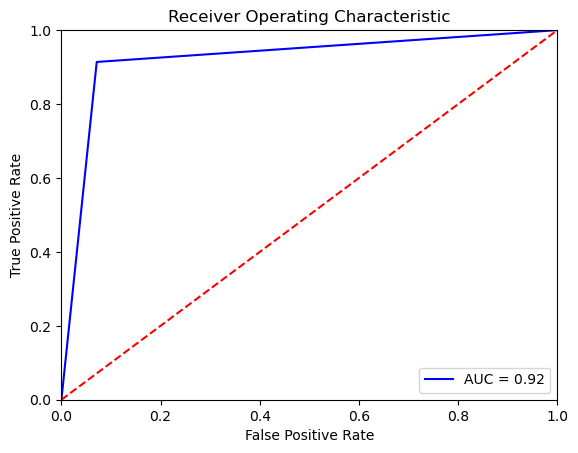

<Axes: >

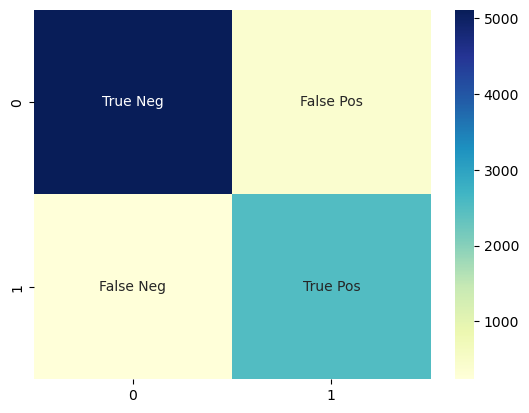

In [67]:
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix(y_test, pipeline2.predict(X_test)),annot = labels,fmt='',cmap = 'YlGnBu')

From the graph shown above (ROC), the greater the AUC, the better is the performance of the model at different threshold points between positive and negative  classes. This simply means that When AUC is 0.94 or almost equal to 1, the classifier is able to perfectly distinguish between all Positive and Negative class points. When AUC is equal to 0, the classifier would be predicting all Negatives as Positives and vice versa. When AUC is 0.5, the classifier is not able to distinguish between the Positive and Negative classes.

In [68]:
# Make dataframes to plot

nb_df = pd.DataFrame(data=[f1_score(y_test,pred),accuracy_score(y_test, pred), recall_score(y_test, pred),
                   precision_score(y_test, pred), roc_auc_score(y_test, pred)], 
             columns=['Naive Bayes Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

kn_df = pd.DataFrame(data=[f1_score(y_test,kNpred),accuracy_score(y_test, kNpred), recall_score(y_test, kNpred),
                   precision_score(y_test, kNpred), roc_auc_score(y_test, kNpred)], 
             columns=['K-neighbor Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

lr_df = pd.DataFrame(data=[f1_score(y_test,y_pred),accuracy_score(y_test, y_pred), recall_score(y_test, y_pred),
                   precision_score(y_test, y_pred), roc_auc_score(y_test, y_pred)], 
             columns=['Logistic Regression Score'],
              index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])         

svm_df = pd.DataFrame(data=[f1_score(y_test,svm_pred),accuracy_score(y_test, svm_pred), recall_score(y_test, svm_pred),
                   precision_score(y_test, svm_pred), roc_auc_score(y_test, svm_pred)], 
             columns=['Support Vector Machine (SVM) Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

XGB_pred_df = pd.DataFrame(data=[f1_score(y_test,XGB_pred),accuracy_score(y_test, XGB_pred), recall_score(y_test, XGB_pred),
                   precision_score(y_test, XGB_pred), roc_auc_score(y_test, XGB_pred)], 
             columns=['XG Boost Score'],
               index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])           

# binary_crossentropy_df = pd.DataFrame(data=[f1_score(y_test,prediction),accuracy_score(y_test, prediction), recall_score(y_test, prediction),
#                    precision_score(y_test, prediction), roc_auc_score(y_test, prediction)], 
#              columns=['binary_crossentropy Score'],
#               index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"]) 

rf_df = pd.DataFrame(data=[f1_score(y_test,preds),accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             columns=['Random Forest Score'],
                index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

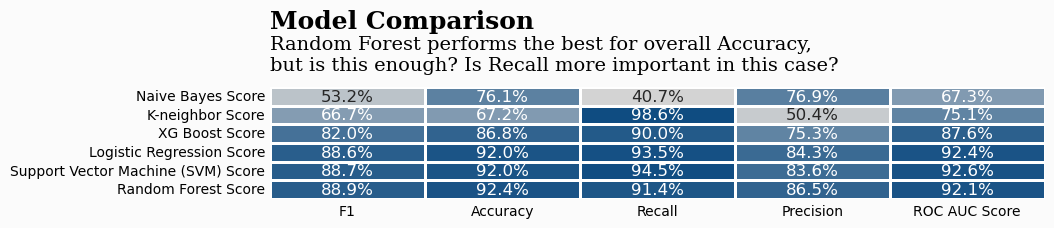

In [69]:
df_models = round(pd.concat([nb_df,kn_df,XGB_pred_df,lr_df,svm_df,rf_df], axis=1),3)
import matplotlib
colors = ["lightgray","lightgray","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(10,8)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=1,cbar=False,ax=ax0,annot_kws={"fontsize":12})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

ax0.text(0,-3.15,'Model Comparison',fontsize=18,fontweight='bold',fontfamily='serif')
ax0.text(0,-0.9,'Random Forest performs the best for overall Accuracy,\nbut is this enough? Is Recall more important in this case?',fontsize=14,fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)


plt.show()

# SHAP- SHapley Additive exPlanations

TreeExplainer only works on tree-based models themselves, not on pipelines or metamodels that end with a tree-based model just like our model.

If we want interpretability in terms of your original features, we need to use the base Explainer class (or equivalently, the KernelExplainer class). Unfortunately, this will be approximate and more computationally expensive.

So our method of choice most suited with LIME as shown below.

# Lime - Local Interpretable Model-agnostic Explanations 

When it comes to model interpretation, sometimes it is useful to unpack and focus on one example at a time.

The LIME package enables just that.

In [70]:
dftest = pd.read_csv('../input/twitter-sentiment-analysis-hatred-speech/test.csv')
dftest.head(10)

id                                              tweet
0  31963  #studiolife #aislife #requires #passion #dedic...
1  31964   @user #white #supremacists want everyone to s...
2  31965  safe ways to heal your #acne!!    #altwaystohe...
3  31966  is the hp and the cursed child book up for res...
4  31967    3rd #bihday to my amazing, hilarious #nephew...
5  31968                        choose to be   :) #momtips 
6  31969  something inside me dies ð¦ð¿â¨  eyes nes...
7  31970  #finished#tattoo#inked#ink#loveitâ¤ï¸ #â¤ï¸...
8  31971   @user @user @user i will never understand why...
9  31972  #delicious   #food #lovelife #capetown mannaep...

In [71]:
train_text = df['tweet']
test_text = dftest['tweet']
all_text = pd.concat([train_text, test_text])

In [72]:
all_text

0        father dysfunctional selfish drag kid dysfunct...
1        thanks lyft credit cant use cause dont offer w...
2                                           bihday majesty
3                              model love u take u time ur
4                            factsguide society motivation
                               ...                        
17192    thought factory: left-right polarisation! #tru...
17193    feeling like a mermaid ð #hairflip #neverre...
17194    #hillary #campaigned today in #ohio((omg)) &am...
17195    happy, at work conference: right mindset leads...
17196    my   song "so glad" free download!  #shoegaze ...
Name: tweet, Length: 46727, dtype: object

In [73]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

**Logistic Regression Classifier**

In [74]:
train_target_raciest = df['label']
classifier_raciest = LogisticRegression(C=0.1, solver='sag')
classifier_raciest.fit(train_word_features, train_target_raciest)

LogisticRegression(C=0.1, solver='sag')

In [75]:
names=['raciest/sexiest','not raciest/sexiest']

In [76]:
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
c_tf = make_pipeline( word_vectorizer,classifier_raciest)
explainer_tf = LimeTextExplainer(class_names=names)

In [77]:
idx = random.randint(1, len(test_text))
# print("Actual Text : ", X_test.iloc[idx])

# print("Prediction : ", pipeline2.predict(X_test.iloc[idx].values.reshape(1,-1))[0])
# print("Actual :     ", y_test.iloc[idx])

exp = explainer_tf.explain_instance(train_text.iloc[idx], c_tf.predict_proba, num_features=10, top_labels=1)
exp.show_in_notebook(text=train_text.iloc[idx])

# ELI5

Feature Weights and Importance
 ELI5 is an acronym for ‘Explain Like I’m 5’ mainly used:

To learn about important features that played a crucial role in predictions.
To analyze a certain individual prediction, and see what exactly led the model to that prediction. 

In [78]:
import eli5
eli5.show_weights(model, vec=vector )

In [79]:
# eli5.show_weights(model, vec=vector, top=100, feature_filter=lambda x: x != '<BIAS>')

In [80]:
# eli5.show_prediction(model, doc=train.values[100], vec=vector)

 Feature Weights and Importance
 ELI5 is an acronym for ‘Explain Like I’m 5’ mainly used:

To learn about important features that played a crucial role in predictions.
To analyze a certain individual prediction, and see what exactly led the model to that prediction. 

# Output

In [81]:
# Now let's make predictions for the test dataset and create a submission file
test_pred = classifier_raciest.predict_proba(test_word_features)
test_pred_int = test_pred[:, 1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
dftest['label'] = test_pred_int
submission = dftest[['id', 'label']]
submission.to_csv('sub_lreg_bow.csv', index = False)

In [82]:
submission.head()

id  label
0  31963      0
1  31964      0
2  31965      0
3  31966      0
4  31967      0

In [83]:
print(f'Checking for null values in data....... \n{submission.isnull().any()}')

Checking for null values in data....... 
id       False
label    False
dtype: bool


In [84]:
submission = submission.drop_duplicates(keep='first')

In [85]:
submission

id  label
0      31963      0
1      31964      0
2      31965      0
3      31966      0
4      31967      0
...      ...    ...
17192  49155      0
17193  49156      0
17194  49157      0
17195  49158      0
17196  49159      0

[17197 rows x 2 columns]

In [86]:
print(f'After checking for duplicates: The shape of the data is {submission.shape}')

After checking for duplicates: The shape of the data is (17197, 2)


In [87]:
print(submission['label'].where(submission['label'] ==1))

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
17192   NaN
17193   NaN
17194   NaN
17195   NaN
17196   NaN
Name: label, Length: 17197, dtype: float64


In [88]:
labelTestOutputCount=Counter(submission['label'])
labelTestOutputCount

Counter({0: 17162, 1: 35})

In [89]:
pos = 100*len(submission.loc[submission['label']==0,'label'])/len(submission['label'])
neg = 100*len(submission.loc[submission['label']==1,'label'])/len(submission['label'])
print(f'Percentage of Not Raciest/Sexiest (Postitive Sentiment) tweets is {pos}')
print(f'Percentage of Raciest/Sexiest (Negative Sentiment) tweets is {neg}')
print('\nClearly, Test data prediction is also heavily Imbalanced')

Percentage of Not Raciest/Sexiest (Postitive Sentiment) tweets is 99.79647612955748
Percentage of Raciest/Sexiest (Negative Sentiment) tweets is 0.20352387044251904

Clearly, Test data prediction is also heavily Imbalanced


> ### Hence we say, tweets contains Postitive Sentiments i.e tweets are Not raciest/sexiest. 

## References

[https://www.kaggle.com/code/tayyabahussaintabz/tayyaba-twitter-sentiment-analysis]

#### Remove Emojis: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
